In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [23]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE,RMSE,MAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

In [24]:
use_col = ['volumn']
data = pd.read_csv('../../traffic/data/3.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,0.220168
1,0.221584
2,0.205680
3,0.185184
4,0.173464
...,...
38875,0.166704
38876,0.172936
38877,0.172976
38878,0.169264


In [25]:
import configparser
import os
config = configparser.ConfigParser()
config['online-learning-DLinear']= {
    'seq_len':1440,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('online-learning-DLinear','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online-learning-DLinear')

['/hdd_1/sjlee/Paper_Project/SelfMadeModelExperiment5/online-learning-DLinear']

In [26]:
class odd_moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(odd_moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [27]:
class even_moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(even_moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [28]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.kernel_size = kernel_size
        self.odd_moving_avg = odd_moving_avg(kernel_size,stride = 1)
        self.even_moving_avg = even_moving_avg(kernel_size,stride = 1)
            
    def forward(self,x):
        if self.kernel_size%2==0:
            moving_mean = self.even_moving_avg(x) #output은 (batch,sequence_length,input_size)
            
        else:
            moving_mean = self.odd_moving_avg(x) #output은 (batch,sequence_length,input_size)
        
        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [29]:
class Model(nn.Module):
    "Decomposition - Linear"
    def __init__(self,configs): # 내가 만든 configure module file
        super(Model,self).__init__()
        self.device = torch.device('cuda:0')
        self.seq_len = int(configs['online-learning-DLinear']['seq_len']) # configure의 sequence length
        self.pred_len = int(configs['online-learning-DLinear']['pred_len']) # configure의 prediction length1
        
        # Decomposition Kernel Size
        small_kernel_size = 4  
        big_kernel_size = 5
        
        self.decomposition1 = series_decomp(small_kernel_size)
        self.decomposition2 = series_decomp(big_kernel_size)
        # residual과 moving_average 값을 받기 위한 decomposition model
        self.individual = configs['online-learning-DLinear']['individual'] # 1) 특성각각에 대해 별도의 layer를 둘것이냐의여부 이고
        self.channels = int(configs['online-learning-DLinear']['enc_in']) # 2) 이때 특성의개수
        
       
        # 현재는 특성 각각에 별도의 layer를 두지 말자고 하면 하나씩의 Layer만 있으면 됨
        self.Linear_Seasonal = nn.Linear(2*self.seq_len,self.pred_len)
        self.Linear_Trend = nn.Linear(2*self.seq_len,self.pred_len)
        self.Linear_plus = nn.Linear(2,1)
            
    def forward(self,x):
        x=x.permute(0,2,1)
        div_factor = x[:,-1,:].view(-1,1,1)
        x = (x-div_factor).permute(0,2,1)
        # x의 size는 [Batch, Input_length, Channel]
        seasonal_init1,trend_init1 = self.decomposition1(x)
        seasonal_init2,trend_init2 = self.decomposition2(x)
        seasonal_init,trend_init = torch.cat([seasonal_init1,seasonal_init2],
                                             dim=2).to(self.device),torch.cat([trend_init1,
                                                                               trend_init2],dim=2).to(self.device)        
        seasonal_output = self.Linear_Seasonal(seasonal_init)    
        trend_output = self.Linear_Trend(trend_init)
        new_input = torch.cat([seasonal_output,trend_output],dim=2)
        
        x = self.Linear_plus(new_input)
        x = x+div_factor
        return x.permute(0,2,1).to(self.device) # batch size, output_length(not sequence_length Layer를 돌면서 크기가 바뀜), channel(feature_size)로 변경해서 return

In [30]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [31]:
torch.manual_seed(42)

In [32]:
sequence_length = 1440
pred_len = 1
split= 10080 #7일(Test Set)
x_data = data.iloc[:-split]
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

In [33]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = Model(config).to(device)
optimizer = Adam(model.parameters(),1e-3)
criterion = SMAPE()
# scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
#                                         lr_lambda=lambda epoch: 1.005 ** epoch,verbose = True)
#                                        # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

In [34]:
torch.manual_seed(42)

In [35]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:

        out = model(seq)
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
    #scheduler.step() #schedular update        
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')        

smape 186.9198222070584 %
smape 154.48196529209267 %
smape 109.52778464215889 %
smape 74.59251681222902 %
smape 48.93330500226969 %
smape 22.036939904703733 %
smape 17.00303547258614 %
smape 14.488247207730835 %
smape 13.330873354223737 %
smape 12.878773482135164 %
smape 11.628482264646314 %
smape 10.712098223946946 %
smape 10.488497412692734 %
smape 10.142091433817182 %
smape 9.876880568196201 %
smape 9.432312704579175 %
smape 9.541880157694482 %
smape 9.41006884545262 %
smape 9.827036073769046 %
smape 9.533078738907625 %
smape 9.650135481653855 %
smape 9.413772606187397 %
smape 9.312926592708331 %
smape 9.567360879733549 %
smape 9.470789308349291 %
smape 9.247939105183757 %
smape 8.935988288786676 %
smape 9.034542874024625 %
smape 9.07547276881006 %
smape 9.081958738858239 %
smape 9.079076899596823 %
smape 8.923144465562894 %
smape 8.950772179149048 %
smape 8.93365956755758 %
smape 9.010180759935352 %
smape 9.117274995000042 %
smape 9.490869800336876 %
smape 8.90420206196127 %
smape 

In [36]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,1,-1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,1,sequence_length).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out = model(new_train) # 예측완료
        
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()
        
#         if epochs == 0:
#             prev_loss = loss
            
#         elif loss < prev_loss:
#             prev_loss=loss
#             torch.save(model,PATH+'/best_model.pt') #모델의 갱신
            
#         running_loss = running_loss + loss.item()
    
#     real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    
#     model = torch.load(PATH+'/best_model.pt')

    real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    with torch.no_grad():
        model.eval()
        real_out = model(real_input)
    model.train()         
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 0.5001532086589577 %
SMAPE 2.0569360194931505 %
SMAPE 0.6726399773906451 %
SMAPE 1.016263557577986 %
SMAPE 0.5483078917422972 %
SMAPE 0.45734290146174317 %
SMAPE 1.5575980978369444 %
SMAPE 0.4067829505947885 %
SMAPE 0.7003592527689761 %
SMAPE 0.1115398600413755 %
SMAPE 0.7246474359362765 %
SMAPE 1.3534379770044325 %
SMAPE 1.9427349955985846 %
SMAPE 0.3406168140027148 %
SMAPE 0.5572826093789445 %
SMAPE 1.7783810752371212 %
SMAPE 0.7432225919637858 %
SMAPE 1.7422722529790917 %
SMAPE 2.2404102111177053 %
SMAPE 0.6724388425391226 %
SMAPE 2.0439677935864893 %
SMAPE 3.8487672078335895 %
SMAPE 1.5264562683805707 %
SMAPE 1.3925459123893233 %
SMAPE 1.1817591238068417 %
SMAPE 1.7937499362087692 %
SMAPE 4.419973868265515 %
SMAPE 0.3917835001266213 %
SMAPE 0.8419986366279772 %
SMAPE 0.6006839186702564 %
SMAPE 0.2269809344006717 %
SMAPE 3.012011438171612 %
SMAPE 0.7770388688149978 %
SMAPE 0.3794901856549586 %
SMAPE 0.889250591210839 %
SMAPE 0.3640381499990326 %
SMAPE 1.7986320932977833 %
SMAP

SMAPE 0.8976664688561867 %
SMAPE 0.49086224939310336 %
SMAPE 1.5429208164530337 %
SMAPE 0.9711587831479845 %
SMAPE 0.6625421734643169 %
SMAPE 0.7251623940537684 %
SMAPE 0.34075701439360273 %
SMAPE 0.13597446005951497 %
SMAPE 0.12289023480161632 %
SMAPE 0.15591905923361082 %
SMAPE 0.7701361105787328 %
SMAPE 5.500876491954841 %
SMAPE 4.554268160944048 %
SMAPE 3.394563424371881 %
SMAPE 6.267418973205167 %
SMAPE 0.8417717170959803 %
SMAPE 1.4986512834029782 %
SMAPE 0.2900126741387794 %
SMAPE 2.250622372019734 %
SMAPE 0.143125173086446 %
SMAPE 0.9646650107752066 %
SMAPE 0.8486814042807964 %
SMAPE 1.0918833358828124 %
SMAPE 3.2037605990080915 %
SMAPE 1.6607314569992013 %
SMAPE 1.2109969409830228 %
SMAPE 0.9873047637993295 %
SMAPE 0.17028758637434294 %
SMAPE 2.8262737597506202 %
SMAPE 0.4956944158839178 %
SMAPE 0.9647959670410273 %
SMAPE 1.1128159438194416 %
SMAPE 0.6537828944638022 %
SMAPE 0.9847550900698252 %
SMAPE 0.8038364013718818 %
SMAPE 0.6349599040840985 %
SMAPE 0.14108741591280705 %


SMAPE 0.2496672196130021 %
SMAPE 0.2003291024639111 %
SMAPE 0.18410863342069206 %
SMAPE 0.28204447007738054 %
SMAPE 0.5217965289872382 %
SMAPE 0.4417609986658136 %
SMAPE 0.7091937047043757 %
SMAPE 0.2649524015869247 %
SMAPE 0.18348076242557454 %
SMAPE 0.6932793203777692 %
SMAPE 1.3448572900163072 %
SMAPE 0.2677185713370136 %
SMAPE 0.6743668721792346 %
SMAPE 0.38290870310527225 %
SMAPE 0.22260059864834145 %
SMAPE 0.5839567501916463 %
SMAPE 0.508352585035027 %
SMAPE 0.8108522895054194 %
SMAPE 0.9756397471828677 %
SMAPE 1.2363234445656417 %
SMAPE 1.6895709933742182 %
SMAPE 0.07553957652999088 %
SMAPE 0.28002529376681196 %
SMAPE 0.5087862194195623 %
SMAPE 0.5062351580072573 %
SMAPE 0.4814594569070323 %
SMAPE 0.9996037054452244 %
SMAPE 1.2558939122100128 %
SMAPE 0.3237575461389497 %
SMAPE 0.9632690661910602 %
SMAPE 1.095473343222693 %
SMAPE 0.07697444299628842 %
SMAPE 0.4093210400296812 %
SMAPE 0.43595124827697873 %
SMAPE 1.249679821478253 %
SMAPE 1.0515981903954525 %
SMAPE 0.62659541701941

SMAPE 0.2650760144533706 %
SMAPE 0.1647988708025423 %
SMAPE 0.4177568247769159 %
SMAPE 0.3172368171112794 %
SMAPE 0.378953245244702 %
SMAPE 0.26180960516830964 %
SMAPE 1.146170320615056 %
SMAPE 0.7065784886252686 %
SMAPE 1.0384319810073066 %
SMAPE 0.9320454164189869 %
SMAPE 0.1341409218894114 %
SMAPE 0.9175724810957036 %
SMAPE 0.1741553136616858 %
SMAPE 0.592427441788459 %
SMAPE 0.4176945178714959 %
SMAPE 0.21432513310719517 %
SMAPE 0.5769031480595004 %
SMAPE 0.6342354500698093 %
SMAPE 0.8341072158400494 %
SMAPE 1.2272619975992711 %
SMAPE 0.3534312977328682 %
SMAPE 0.12712058217812228 %
SMAPE 1.2529462420352502 %
SMAPE 0.48161478561451077 %
SMAPE 0.2620255297388212 %
SMAPE 0.47511728879180737 %
SMAPE 0.8955691066039434 %
SMAPE 0.38770084197312826 %
SMAPE 1.181833200600522 %
SMAPE 1.3490216936970683 %
SMAPE 0.32769640354672447 %
SMAPE 0.1988918174729406 %
SMAPE 0.32184281004629156 %
SMAPE 0.3149143102582457 %
SMAPE 0.8578493594686734 %
SMAPE 0.23332461553764008 %
SMAPE 0.315234313806286

SMAPE 0.9960712715692353 %
SMAPE 0.11684142501871976 %
SMAPE 0.2952470176373936 %
SMAPE 0.43962832394936413 %
SMAPE 0.7687120178254645 %
SMAPE 0.718871386587125 %
SMAPE 0.399663392578077 %
SMAPE 1.0262170750465884 %
SMAPE 1.4594235023541842 %
SMAPE 0.886020804362488 %
SMAPE 0.49767914233962074 %
SMAPE 0.6161104318525759 %
SMAPE 0.45279627656782395 %
SMAPE 0.4830172082547506 %
SMAPE 1.059514086744457 %
SMAPE 0.1768549631915448 %
SMAPE 0.36217217121156864 %
SMAPE 0.6415470984029525 %
SMAPE 0.7119371922653954 %
SMAPE 0.19250002837543434 %
SMAPE 1.3173251859770971 %
SMAPE 0.3888239116240584 %
SMAPE 0.887629687145818 %
SMAPE 0.4209663987112435 %
SMAPE 0.24415746763770588 %
SMAPE 0.9213150726136519 %
SMAPE 0.4830407800764078 %
SMAPE 0.7973749008015149 %
SMAPE 1.2371688598723267 %
SMAPE 0.23192270873914822 %
SMAPE 2.581724228220992 %
SMAPE 0.83710106088256 %
SMAPE 0.5795834448363166 %
SMAPE 0.7475882392463973 %
SMAPE 1.4408122817112599 %
SMAPE 0.9354200283705723 %
SMAPE 0.9016088977950858 %
S

SMAPE 0.1646151957284019 %
SMAPE 0.4366046482173261 %
SMAPE 0.4219759512125165 %
SMAPE 0.4751338848291198 %
SMAPE 0.16612020868217314 %
SMAPE 0.5942019564827206 %
SMAPE 0.2365689070247754 %
SMAPE 0.35082602628335735 %
SMAPE 0.6745307135497569 %
SMAPE 0.23230147058893635 %
SMAPE 0.16286945471074432 %
SMAPE 1.6791267566441095 %
SMAPE 0.6107457196503674 %
SMAPE 0.5847909802469076 %
SMAPE 0.20771579656593528 %
SMAPE 0.637070706593704 %
SMAPE 0.3834515740913673 %
SMAPE 2.01284858652798 %
SMAPE 1.872916408227866 %
SMAPE 0.7502542912607169 %
SMAPE 0.7754086349377758 %
SMAPE 1.2138966229686048 %
SMAPE 0.4294066911388655 %
SMAPE 0.5939443768002093 %
SMAPE 0.4095599678585131 %
SMAPE 0.3025766993741854 %
SMAPE 0.07108997247723892 %
SMAPE 0.9160584800556535 %
SMAPE 0.5339814117760397 %
SMAPE 0.2179388536787883 %
SMAPE 0.14763271545052703 %
SMAPE 0.33247446870700514 %
SMAPE 0.6341323891792854 %
SMAPE 0.4560697032065946 %
SMAPE 0.30859597165544983 %
SMAPE 0.21380130757461302 %
SMAPE 0.25082700377060

SMAPE 0.4393434682715452 %
SMAPE 1.6087308809719616 %
SMAPE 0.3298766490770504 %
SMAPE 0.5847898099491431 %
SMAPE 0.5089952434775569 %
SMAPE 0.6386902981357707 %
SMAPE 1.078670161725313 %
SMAPE 0.2915969829336973 %
SMAPE 0.3455501743014793 %
SMAPE 1.1138082012912491 %
SMAPE 0.552639110796008 %
SMAPE 0.15659769574449456 %
SMAPE 0.07858767414336398 %
SMAPE 0.5195429059131129 %
SMAPE 0.8494151305822015 %
SMAPE 2.8139652578684036 %
SMAPE 0.8504604692861903 %
SMAPE 0.2836262344426359 %
SMAPE 3.4412932355317025 %
SMAPE 7.3774796836327 %
SMAPE 5.717773764690719 %
SMAPE 0.41114991794165684 %
SMAPE 0.25767900860773807 %
SMAPE 0.9814705408280133 %
SMAPE 0.10398065090930686 %
SMAPE 0.6592239139927187 %
SMAPE 0.6391894147636776 %
SMAPE 0.4496971492658304 %
SMAPE 1.913056562852944 %
SMAPE 1.821758815058274 %
SMAPE 0.7213971561777726 %
SMAPE 1.6351164763218549 %
SMAPE 0.5483904795621584 %
SMAPE 0.16706811703943458 %
SMAPE 1.623689740719783 %
SMAPE 3.8310575929790502 %
SMAPE 0.22884500573491096 %
SMA

SMAPE 0.7036773377203644 %
SMAPE 0.4120418174616134 %
SMAPE 1.7049065713363236 %
SMAPE 3.1093851256810012 %
SMAPE 6.36140916479053 %
SMAPE 1.1812505011403118 %
SMAPE 0.44070174243097426 %
SMAPE 1.3109645509139227 %
SMAPE 0.38176892993215006 %
SMAPE 0.15829986835524323 %
SMAPE 0.26817307571764104 %
SMAPE 0.5210805497918045 %
SMAPE 1.2300750947542838 %
SMAPE 0.6403120667819167 %
SMAPE 0.3056891784799518 %
SMAPE 0.3683260679476916 %
SMAPE 0.6957708769550663 %
SMAPE 0.5486281589237478 %
SMAPE 0.709867205536284 %
SMAPE 0.15051325171771168 %
SMAPE 0.2576357552134141 %
SMAPE 0.17389592157996958 %
SMAPE 0.4726124162625638 %
SMAPE 0.2938173673774145 %
SMAPE 0.20518833555979657 %
SMAPE 0.42354141971372883 %
SMAPE 0.5794118874400738 %
SMAPE 0.3588545153288578 %
SMAPE 1.2628875231421262 %
SMAPE 0.4525424961466342 %
SMAPE 0.21768351455284576 %
SMAPE 0.18178403790352604 %
SMAPE 0.9099796096998035 %
SMAPE 0.47275133872153674 %
SMAPE 0.16511157227068907 %
SMAPE 0.14435820410653832 %
SMAPE 1.0750698744

SMAPE 1.6838534100097602 %
SMAPE 1.7523144507249524 %
SMAPE 2.3547798912841245 %
SMAPE 0.552897992056387 %
SMAPE 1.914857687936319 %
SMAPE 0.9972441024729051 %
SMAPE 0.7212349675137375 %
SMAPE 1.1203057960719889 %
SMAPE 0.4377873635366996 %
SMAPE 0.5340592915345042 %
SMAPE 4.318661277909996 %
SMAPE 1.1615078311297111 %
SMAPE 1.7517458939837522 %
SMAPE 0.21382083479329594 %
SMAPE 0.1757614896632731 %
SMAPE 0.45909994836983964 %
SMAPE 0.6820188926858464 %
SMAPE 0.3419844203090179 %
SMAPE 0.5497368716351048 %
SMAPE 0.6751435882695205 %
SMAPE 1.4516318697860697 %
SMAPE 0.34431043644656256 %
SMAPE 0.21304943389441178 %
SMAPE 0.7739461519249744 %
SMAPE 0.5478841849071614 %
SMAPE 0.5351841415613308 %
SMAPE 0.13777999891863146 %
SMAPE 0.4623762884803 %
SMAPE 0.2593849776449133 %
SMAPE 0.27146854923717 %
SMAPE 2.151800439154613 %
SMAPE 0.36924224221729673 %
SMAPE 0.26067958777639433 %
SMAPE 0.6077685923955869 %
SMAPE 1.6047096301772399 %
SMAPE 0.7043770990305802 %
SMAPE 0.34623204903437 %
SMAPE

SMAPE 1.9236660418046085 %
SMAPE 0.4289447690243833 %
SMAPE 0.38056849688837247 %
SMAPE 0.24843551656613272 %
SMAPE 0.6708095821750248 %
SMAPE 0.630489110283861 %
SMAPE 0.442737644771114 %
SMAPE 0.7019050766612054 %
SMAPE 2.2381326538306894 %
SMAPE 0.52697560857996 %
SMAPE 0.4040064206665761 %
SMAPE 1.3925024986383505 %
SMAPE 0.7461170329333981 %
SMAPE 0.4858140283395187 %
SMAPE 0.8788235106517278 %
SMAPE 0.7907186031188759 %
SMAPE 0.12093792213636334 %
SMAPE 0.3306297051267393 %
SMAPE 0.6502415590039163 %
SMAPE 1.0614589185479417 %
SMAPE 0.9520475688659644 %
SMAPE 0.19670983519608853 %
SMAPE 0.3160547580191633 %
SMAPE 0.9516348635952455 %
SMAPE 0.12606139966919727 %
SMAPE 0.18761903662380064 %
SMAPE 0.22616037593274993 %
SMAPE 0.18637251983454917 %
SMAPE 0.6611818104047416 %
SMAPE 0.23576287359901468 %
SMAPE 0.7190943447908467 %
SMAPE 0.45944147245609196 %
SMAPE 0.498011856312587 %
SMAPE 0.1531631750285669 %
SMAPE 0.9854549443261931 %
SMAPE 0.490402397204889 %
SMAPE 0.3304031802217650

SMAPE 2.335877802936011 %
SMAPE 0.6624981386012223 %
SMAPE 1.1859450549491157 %
SMAPE 0.24377219184395926 %
SMAPE 1.0071559275265827 %
SMAPE 0.6278468339041865 %
SMAPE 3.253695627376146 %
SMAPE 0.23661355838885356 %
SMAPE 1.1302432332995522 %
SMAPE 0.8052176349419824 %
SMAPE 0.8275889060823829 %
SMAPE 1.194334038758825 %
SMAPE 0.638694265581762 %
SMAPE 0.777507204666108 %
SMAPE 0.43476687552174553 %
SMAPE 0.7767243711314222 %
SMAPE 1.792876865602011 %
SMAPE 0.27697685833845753 %
SMAPE 0.497470193044137 %
SMAPE 0.3687284772554449 %
SMAPE 0.43180382143236784 %
SMAPE 0.26643895862844147 %
SMAPE 0.21155596221433373 %
SMAPE 0.48152101536970804 %
SMAPE 0.31621094693218765 %
SMAPE 0.4060916121998162 %
SMAPE 1.0777354641249985 %
SMAPE 0.15546187828294933 %
SMAPE 0.3171367714030566 %
SMAPE 0.39049500248256663 %
SMAPE 1.1431443859601131 %
SMAPE 0.4097723124286859 %
SMAPE 0.21699412766065504 %
SMAPE 0.6332926614686585 %
SMAPE 0.7336787490364713 %
SMAPE 0.5773177410974313 %
SMAPE 1.244854401113116

SMAPE 0.54833548769966 %
SMAPE 0.7052400892971491 %
SMAPE 0.4948294526911923 %
SMAPE 2.5510419265037854 %
SMAPE 0.5814700277805969 %
SMAPE 0.45407222789253865 %
SMAPE 0.27400167039195367 %
SMAPE 0.643794386582158 %
SMAPE 0.2798847544618184 %
SMAPE 0.9211551041989878 %
SMAPE 0.43448474208616966 %
SMAPE 0.9932922743646486 %
SMAPE 0.3986001346202101 %
SMAPE 1.7688852862993372 %
SMAPE 0.13936063411529176 %
SMAPE 0.2821407000919862 %
SMAPE 0.2250927459426748 %
SMAPE 0.3492010023401235 %
SMAPE 0.7179342988820281 %
SMAPE 0.2672438581450933 %
SMAPE 0.6065028836746933 %
SMAPE 0.7401302098719498 %
SMAPE 0.11905866736560711 %
SMAPE 0.5209066995103058 %
SMAPE 0.6000808063545264 %
SMAPE 0.6128048193760378 %
SMAPE 0.6861868792275345 %
SMAPE 1.1017541906076076 %
SMAPE 0.27297231974444003 %
SMAPE 0.37095840483743814 %
SMAPE 0.77986293394315 %
SMAPE 0.9828586791659291 %
SMAPE 0.08322708351988695 %
SMAPE 4.2658340202324325 %
SMAPE 0.8313580043031834 %
SMAPE 0.6442993965138157 %
SMAPE 0.18034153399867137

SMAPE 1.043875085628315 %
SMAPE 2.4836525115460972 %
SMAPE 0.5978500679884746 %
SMAPE 0.429248746491794 %
SMAPE 0.9364232294610703 %
SMAPE 0.6637538476607006 %
SMAPE 0.5228213661139307 %
SMAPE 1.8687409919148195 %
SMAPE 0.13003208978352632 %
SMAPE 0.09923090528172906 %
SMAPE 1.0190853557141963 %
SMAPE 0.8281185358391667 %
SMAPE 1.6609218130797674 %
SMAPE 0.43117287761197076 %
SMAPE 0.2676915764473051 %
SMAPE 0.36045110949362424 %
SMAPE 0.3288382397586247 %
SMAPE 0.1730818713149347 %
SMAPE 0.5509098850779992 %
SMAPE 0.5692795832728734 %
SMAPE 1.1625874946112162 %
SMAPE 2.1078607357012515 %
SMAPE 0.5005117876589793 %
SMAPE 0.6600569666920819 %
SMAPE 0.5065478503056511 %
SMAPE 1.2322449835701264 %
SMAPE 0.9318137871105137 %
SMAPE 1.0575786514959873 %
SMAPE 0.7550525080005173 %
SMAPE 0.33904890379744757 %
SMAPE 0.1172347984447697 %
SMAPE 3.4447537236119388 %
SMAPE 0.2310476398706669 %
SMAPE 0.3134722473605507 %
SMAPE 0.6111756169484579 %
SMAPE 0.1432628590046079 %
SMAPE 0.319303347463574 %

SMAPE 0.7188443192972045 %
SMAPE 0.7917982960570953 %
SMAPE 0.45000793414965307 %
SMAPE 0.3192855231683325 %
SMAPE 0.4857092994226378 %
SMAPE 0.3314769438995455 %
SMAPE 0.8088333397045061 %
SMAPE 0.3916967603727244 %
SMAPE 1.4109777653125093 %
SMAPE 0.2682699848610355 %
SMAPE 0.27830210679348966 %
SMAPE 0.5318881244456861 %
SMAPE 0.17324900924540998 %
SMAPE 0.5294986351073021 %
SMAPE 0.18263681776807061 %
SMAPE 0.10766741735096728 %
SMAPE 0.259659595343237 %
SMAPE 0.22662099773833685 %
SMAPE 1.1713956096791662 %
SMAPE 0.6540375479780778 %
SMAPE 0.6304013681401557 %
SMAPE 0.36466617680366653 %
SMAPE 0.23161892953044116 %
SMAPE 0.3293123328803631 %
SMAPE 1.5024837566897986 %
SMAPE 0.3129951627649916 %
SMAPE 0.19756886525601658 %
SMAPE 0.6490869557046608 %
SMAPE 1.5121519623789936 %
SMAPE 0.7288615206052782 %
SMAPE 1.0131334196776152 %
SMAPE 0.6244146901126442 %
SMAPE 0.28860284484926524 %
SMAPE 0.5587546688238945 %
SMAPE 0.35099696769657385 %
SMAPE 1.029906639139881 %
SMAPE 0.26657602816

SMAPE 0.23077122185350163 %
SMAPE 0.6717923218729993 %
SMAPE 0.326110960517326 %
SMAPE 0.2708536676244364 %
SMAPE 0.24441626308896502 %
SMAPE 0.4496123290796277 %
SMAPE 0.2070566304046224 %
SMAPE 0.4387467801770981 %
SMAPE 0.12873535927337798 %
SMAPE 0.11215517360483318 %
SMAPE 0.15377469526902132 %
SMAPE 0.5530098424233074 %
SMAPE 0.963176033131731 %
SMAPE 0.7113650711253285 %
SMAPE 0.24920263293188327 %
SMAPE 1.999456376033777 %
SMAPE 0.7595100880535028 %
SMAPE 1.720416319346441 %
SMAPE 0.3668302365404088 %
SMAPE 0.29631672110372165 %
SMAPE 0.9605482439583283 %
SMAPE 0.6629474021956412 %
SMAPE 0.8169161454843562 %
SMAPE 0.3344461223714461 %
SMAPE 0.28379840985326155 %
SMAPE 0.9728132810723764 %
SMAPE 1.3147862711898597 %
SMAPE 2.955088784612599 %
SMAPE 0.6806594212030177 %
SMAPE 0.4904667224836885 %
SMAPE 0.205886400595773 %
SMAPE 0.3743830350065309 %
SMAPE 1.3566153720239527 %
SMAPE 0.8591296154263547 %
SMAPE 1.9726915163173546 %
SMAPE 1.301836584171724 %
SMAPE 0.9118324363371357 %


SMAPE 1.421291311483401 %
SMAPE 0.4399557240103605 %
SMAPE 0.4005116408770846 %
SMAPE 0.23764586303605031 %
SMAPE 0.7009252242942239 %
SMAPE 0.45549093897534476 %
SMAPE 0.8032354216209115 %
SMAPE 0.9542357806931251 %
SMAPE 0.6994199034179474 %
SMAPE 1.0819867365644313 %
SMAPE 1.7677313870344733 %
SMAPE 1.1904516969952965 %
SMAPE 0.23009417192224646 %
SMAPE 1.2549459483561805 %
SMAPE 2.013274719362016 %
SMAPE 0.2499293352939276 %
SMAPE 0.2903450288140448 %
SMAPE 1.7912293239846804 %
SMAPE 1.0691401567892171 %
SMAPE 1.2698607145684946 %
SMAPE 5.53697239948815 %
SMAPE 9.455371781892609 %
SMAPE 2.0411188630787365 %
SMAPE 1.0280597225441852 %
SMAPE 4.694624923540687 %
SMAPE 0.28608328603513655 %
SMAPE 0.49553148282393517 %
SMAPE 0.7090618037782406 %
SMAPE 0.6206038811069448 %
SMAPE 0.9373567173315677 %
SMAPE 0.23951515552471395 %
SMAPE 1.5803649252857215 %
SMAPE 1.0542962828767486 %
SMAPE 0.8023223187519761 %
SMAPE 3.114872834561538 %
SMAPE 0.40815326637311955 %
SMAPE 0.5262405004996253 %
S

SMAPE 0.410782092694717 %
SMAPE 0.4920332925903495 %
SMAPE 0.15207019261288224 %
SMAPE 0.17156393760342326 %
SMAPE 1.507747367486445 %
SMAPE 5.388677889102837 %
SMAPE 0.6279369593576121 %
SMAPE 0.19910987042385386 %
SMAPE 0.36979627715118113 %
SMAPE 0.6930657592019998 %
SMAPE 1.1844273656388395 %
SMAPE 0.8131465719925473 %
SMAPE 0.7432801771105915 %
SMAPE 0.34081900643104746 %
SMAPE 0.28773962473223946 %
SMAPE 0.17887035955391184 %
SMAPE 0.8852818419400136 %
SMAPE 0.3766939602937782 %
SMAPE 0.7191288302028624 %
SMAPE 1.0923462495557033 %
SMAPE 0.4134056952643732 %
SMAPE 2.935260543425102 %
SMAPE 0.5175347170516034 %
SMAPE 0.13299667908813717 %
SMAPE 1.2442944492522656 %
SMAPE 1.2693851009753416 %
SMAPE 0.2909482340073737 %
SMAPE 0.4315452088339953 %
SMAPE 0.3042684362753789 %
SMAPE 0.17369251511718176 %
SMAPE 0.8308588609579601 %
SMAPE 1.085180457230308 %
SMAPE 0.13611519198821043 %
SMAPE 0.44483451457927004 %
SMAPE 0.23857868603954557 %
SMAPE 0.9295765497099637 %
SMAPE 0.1711289203376

SMAPE 0.5779462625948781 %
SMAPE 0.871646731452529 %
SMAPE 0.6059977004806569 %
SMAPE 0.2152681788465998 %
SMAPE 0.35318419697432546 %
SMAPE 1.4346844893007074 %
SMAPE 1.0382845447129512 %
SMAPE 0.15309930131479632 %
SMAPE 0.06632903291028924 %
SMAPE 0.25669627844399656 %
SMAPE 0.5416341065065353 %
SMAPE 2.213696156104561 %
SMAPE 0.942169898589782 %
SMAPE 0.19188377978571225 %
SMAPE 0.36718105003456003 %
SMAPE 0.7238818858313607 %
SMAPE 0.38682733771156563 %
SMAPE 0.2489117527943563 %
SMAPE 0.1952173438767204 %
SMAPE 1.14551772348932 %
SMAPE 0.22648818006928195 %
SMAPE 0.25122629161342047 %
SMAPE 0.2528187419882215 %
SMAPE 0.5900597981130886 %
SMAPE 0.13742629626722191 %
SMAPE 0.18451849562552525 %
SMAPE 1.0959220787444792 %
SMAPE 0.5597244265518384 %
SMAPE 0.20530451364902547 %
SMAPE 1.408454590869951 %
SMAPE 0.389678114974231 %
SMAPE 0.633699967604116 %
SMAPE 0.5485381640662581 %
SMAPE 0.8436335451624472 %
SMAPE 0.7740151631951449 %
SMAPE 0.5958795980914147 %
SMAPE 0.9572596143261762

SMAPE 0.2599313971581978 %
SMAPE 1.0864690632042766 %
SMAPE 1.0823825308834785 %
SMAPE 0.3422113766591792 %
SMAPE 0.41381587322575797 %
SMAPE 1.0685476740234208 %
SMAPE 0.16006900603315444 %
SMAPE 0.8270892874970742 %
SMAPE 0.3819853389868513 %
SMAPE 0.09467590856911556 %
SMAPE 0.2999729743823991 %
SMAPE 1.1528750743345881 %
SMAPE 1.517276342936384 %
SMAPE 0.7983286899107043 %
SMAPE 0.2427883561408635 %
SMAPE 0.11501314171800915 %
SMAPE 0.3674462484486867 %
SMAPE 2.048977215308696 %
SMAPE 0.3806478387014067 %
SMAPE 0.6928694068810728 %
SMAPE 1.018467177353159 %
SMAPE 0.5298940293605483 %
SMAPE 0.3623073213138923 %
SMAPE 2.023611373064341 %
SMAPE 0.7089115541020874 %
SMAPE 0.5188033128206371 %
SMAPE 0.6062957249105239 %
SMAPE 1.014308374706161 %
SMAPE 0.4255473245757457 %
SMAPE 1.1168925313631917 %
SMAPE 0.47490362474127323 %
SMAPE 0.14923576606088318 %
SMAPE 0.8088342801966065 %
SMAPE 0.22800677630948485 %
SMAPE 0.1516331794700818 %
SMAPE 0.16521808917514136 %
SMAPE 0.7833379288349533 

SMAPE 1.593633046722971 %
SMAPE 0.18064953698922182 %
SMAPE 0.8938128225017862 %
SMAPE 1.071935943167773 %
SMAPE 0.14978571211577218 %
SMAPE 0.4949828695243923 %
SMAPE 0.7224456323335744 %
SMAPE 0.6501671557716691 %
SMAPE 0.18527012221147743 %
SMAPE 0.40589810953497363 %
SMAPE 1.5340827786931186 %
SMAPE 0.9876708862138912 %
SMAPE 0.2656239665079738 %
SMAPE 0.7590938379835279 %
SMAPE 0.6885608581796987 %
SMAPE 1.2475655667058163 %
SMAPE 1.2666356454119523 %
SMAPE 0.5967336003232049 %
SMAPE 0.5379500525996264 %
SMAPE 0.7265169257007074 %
SMAPE 0.3277644006502669 %
SMAPE 0.26264250410167733 %
SMAPE 0.1992002440529177 %
SMAPE 0.4468127251311671 %
SMAPE 0.1702123416403083 %
SMAPE 1.3329899812033545 %
SMAPE 0.19944431017211176 %
SMAPE 0.25903452546845074 %
SMAPE 1.169442512713431 %
SMAPE 0.3493037006933264 %
SMAPE 1.7218431417131796 %
SMAPE 0.6080156585958321 %
SMAPE 0.4595743055015191 %
SMAPE 1.3751581561009516 %
SMAPE 0.7508006016396394 %
SMAPE 0.8474445621068298 %
SMAPE 0.4290441023140374

SMAPE 0.47185478897881694 %
SMAPE 0.7457318226151983 %
SMAPE 0.7276258904457791 %
SMAPE 0.5325932363812171 %
SMAPE 0.830325651005296 %
SMAPE 0.4851692367847136 %
SMAPE 2.150593116210075 %
SMAPE 0.7028829857190431 %
SMAPE 0.3890284681629055 %
SMAPE 0.6269334655444254 %
SMAPE 0.25797336624691525 %
SMAPE 1.011889438067783 %
SMAPE 0.5234161595467413 %
SMAPE 0.6134441994472581 %
SMAPE 0.5273221278470146 %
SMAPE 3.785281757824123 %
SMAPE 0.4417059188381245 %
SMAPE 0.7868599932116922 %
SMAPE 0.20571810783803812 %
SMAPE 1.3489775655107223 %
SMAPE 1.296601681611719 %
SMAPE 1.3676605183281936 %
SMAPE 0.5444312606559834 %
SMAPE 0.4217967997560663 %
SMAPE 1.6803799827548573 %
SMAPE 5.4655978819937445 %
SMAPE 0.33310855980926135 %
SMAPE 1.2153791359378374 %
SMAPE 0.17187887669115298 %
SMAPE 0.44418197981576674 %
SMAPE 1.421251192886075 %
SMAPE 0.7225640148026287 %
SMAPE 0.5724771001905538 %
SMAPE 0.44854811004749706 %
SMAPE 2.0037890544190304 %
SMAPE 4.856032796800719 %
SMAPE 0.8075796634275321 %
S

SMAPE 0.7564510195788898 %
SMAPE 1.033722633641446 %
SMAPE 1.5415256604755996 %
SMAPE 0.4795235728670378 %
SMAPE 0.49104052648181096 %
SMAPE 0.3403552295640111 %
SMAPE 0.6683349911254481 %
SMAPE 0.810280363613856 %
SMAPE 0.7287348948307226 %
SMAPE 0.371500357905461 %
SMAPE 0.5007362222895608 %
SMAPE 1.2512311179802964 %
SMAPE 0.6828311684694199 %
SMAPE 0.7937824860018736 %
SMAPE 0.29284775466658175 %
SMAPE 0.4436936450365465 %
SMAPE 0.5215861375809254 %
SMAPE 0.2883309063181514 %
SMAPE 0.1051533450736315 %
SMAPE 0.621356406315897 %
SMAPE 0.4048600787036776 %
SMAPE 0.24614157415999213 %
SMAPE 1.178789681813214 %
SMAPE 1.6028556606324855 %
SMAPE 0.9043824965774547 %
SMAPE 1.0925028890560498 %
SMAPE 1.199197094378178 %
SMAPE 1.0911813504899328 %
SMAPE 1.3546399199040025 %
SMAPE 0.9141748108686444 %
SMAPE 0.3787485034090423 %
SMAPE 0.31398062599328114 %
SMAPE 1.6180181218305734 %
SMAPE 0.21207812070133514 %
SMAPE 0.2548829099323484 %
SMAPE 0.5239696970966179 %
SMAPE 0.9304104642560561 %
SM

SMAPE 0.5826647370122373 %
SMAPE 1.0705388001806568 %
SMAPE 0.8504110042414368 %
SMAPE 0.35594434441827616 %
SMAPE 1.2759193963429425 %
SMAPE 0.46242394059299835 %
SMAPE 0.18893510649286327 %
SMAPE 0.276580599918816 %
SMAPE 0.6884994315078075 %
SMAPE 1.1592488263668201 %
SMAPE 1.345263585486009 %
SMAPE 0.5008674808112801 %
SMAPE 0.12977445144861122 %
SMAPE 0.3991131077091268 %
SMAPE 0.243556046325466 %
SMAPE 0.8533316345865387 %
SMAPE 0.23572797695669578 %
SMAPE 0.583430503781301 %
SMAPE 0.9361588601859695 %
SMAPE 0.5677363505774338 %
SMAPE 2.3794463261583587 %
SMAPE 0.4601896591084369 %
SMAPE 1.169816182264185 %
SMAPE 0.8047327756921732 %
SMAPE 0.349347478056643 %
SMAPE 0.21735602490650766 %
SMAPE 0.3598312238418657 %
SMAPE 0.8521503676356589 %
SMAPE 0.41243281038987334 %
SMAPE 1.1545559764017526 %
SMAPE 0.5357136114071182 %
SMAPE 0.44448927045596065 %
SMAPE 1.3647477573083506 %
SMAPE 0.10512644454092879 %
SMAPE 0.3810936087029404 %
SMAPE 0.45342804093161254 %
SMAPE 1.4230005351419095

SMAPE 0.22496273313299753 %
SMAPE 0.725366199410928 %
SMAPE 3.0083020818128716 %
SMAPE 0.06635241891308397 %
SMAPE 0.41223698498652084 %
SMAPE 0.10336622333124978 %
SMAPE 0.6037415192113258 %
SMAPE 0.44294711574002577 %
SMAPE 0.9386378217859601 %
SMAPE 1.0956594648487226 %
SMAPE 0.49849058960808174 %
SMAPE 0.31454569854008696 %
SMAPE 0.4273035887972582 %
SMAPE 0.9142097151986377 %
SMAPE 0.2340448432951234 %
SMAPE 0.15430436429960537 %
SMAPE 0.5776298818964278 %
SMAPE 0.39480168780937674 %
SMAPE 0.17560169912394485 %
SMAPE 0.46884618144758855 %
SMAPE 0.18338909770136524 %
SMAPE 0.21484985123606748 %
SMAPE 0.6872161485953256 %
SMAPE 0.39765358078147983 %
SMAPE 0.6020014440855448 %
SMAPE 1.0119913631788222 %
SMAPE 0.6772223939078685 %
SMAPE 0.29155014542448043 %
SMAPE 0.7938933977548003 %
SMAPE 0.46266648959135637 %
SMAPE 0.6488973680388881 %
SMAPE 0.4339651862428582 %
SMAPE 0.9517912649808123 %
SMAPE 0.3577308908061241 %
SMAPE 1.095712092344911 %
SMAPE 1.3527255922163022 %
SMAPE 0.224393

SMAPE 1.563609327589802 %
SMAPE 0.11049125945737616 %
SMAPE 0.17141034416636103 %
SMAPE 0.783482716423805 %
SMAPE 0.7365461286244681 %
SMAPE 0.4687048433253267 %
SMAPE 0.4971634353605623 %
SMAPE 0.39110583920421504 %
SMAPE 0.7681543660628449 %
SMAPE 1.1717904585002543 %
SMAPE 0.6628744285499124 %
SMAPE 0.4595072675438132 %
SMAPE 0.9497527307730705 %
SMAPE 0.39892151793173974 %
SMAPE 1.1217201998770179 %
SMAPE 0.5314006652206444 %
SMAPE 0.16178985320584616 %
SMAPE 0.2759763603526153 %
SMAPE 0.5160619766320451 %
SMAPE 0.18656792535421118 %
SMAPE 0.31204843016530504 %
SMAPE 0.5018977499394168 %
SMAPE 0.2754706101291049 %
SMAPE 0.6995900436777447 %
SMAPE 1.6794314626794176 %
SMAPE 0.40281917930406047 %
SMAPE 0.24684715766488807 %
SMAPE 0.5179179480110179 %
SMAPE 0.4806734333992608 %
SMAPE 1.5297562192108671 %
SMAPE 0.7181243421218824 %
SMAPE 1.81842836728174 %
SMAPE 0.21267010243718687 %
SMAPE 0.2637902159390251 %
SMAPE 0.3814521605545451 %
SMAPE 0.42401387379618427 %
SMAPE 0.6430452830036

SMAPE 0.46897117423316104 %
SMAPE 0.8809471257263795 %
SMAPE 0.23443643380085177 %
SMAPE 0.4762164880230557 %
SMAPE 0.2653935975931745 %
SMAPE 0.32261918151925784 %
SMAPE 1.173434056534461 %
SMAPE 1.1291756834336866 %
SMAPE 0.35698893037624657 %
SMAPE 0.31192766995809507 %
SMAPE 0.4878528303861458 %
SMAPE 1.0191507688505226 %
SMAPE 0.8356003653898371 %
SMAPE 0.43921767897518293 %
SMAPE 0.7095700048230356 %
SMAPE 1.5800661379034864 %
SMAPE 1.2902408658264903 %
SMAPE 3.021073362459447 %
SMAPE 4.03859870188171 %
SMAPE 0.9273852774003898 %
SMAPE 0.7063238417104003 %
SMAPE 0.5979864426699351 %
SMAPE 0.5581991621766065 %
SMAPE 0.515847604314331 %
SMAPE 0.6851273385764216 %
SMAPE 0.8620997262796662 %
SMAPE 1.4197864131783717 %
SMAPE 0.22158410146948881 %
SMAPE 0.15434842682770977 %
SMAPE 1.8865843312596553 %
SMAPE 4.550806472252589 %
SMAPE 1.3977362728146545 %
SMAPE 0.4910265871239971 %
SMAPE 0.5594254823715801 %
SMAPE 1.008225751847931 %
SMAPE 0.8396683714108804 %
SMAPE 0.5179016472102376 %


SMAPE 0.20100692351934413 %
SMAPE 0.6056992678040842 %
SMAPE 0.26343172534780024 %
SMAPE 0.9285782689112239 %
SMAPE 0.35264578437636374 %
SMAPE 0.09394269088443252 %
SMAPE 0.1020848411269526 %
SMAPE 0.692456227610819 %
SMAPE 0.5160752534029598 %
SMAPE 1.0317294139886144 %
SMAPE 1.9166036966780666 %
SMAPE 0.35980427077402055 %
SMAPE 0.4956867367745872 %
SMAPE 0.24955399029386172 %
SMAPE 0.26248394152389665 %
SMAPE 0.20343278902510065 %
SMAPE 0.17331860541935384 %
SMAPE 0.6260205400540144 %
SMAPE 0.7052041233764612 %
SMAPE 0.45103558286245965 %
SMAPE 0.11189770852388392 %
SMAPE 0.37841367373766843 %
SMAPE 0.22092496631375982 %
SMAPE 0.4889945841132431 %
SMAPE 0.19840219443494786 %
SMAPE 0.848797813319834 %
SMAPE 3.683690818550531 %
SMAPE 0.8933046739575728 %
SMAPE 0.4648237700712344 %
SMAPE 6.692392684213701 %
SMAPE 5.5974619669723324 %
SMAPE 0.17703285097559274 %
SMAPE 0.7599490147986216 %
SMAPE 0.3624951542242343 %
SMAPE 1.5574228229852451 %
SMAPE 1.2321939050234505 %
SMAPE 0.974974164

SMAPE 1.2797446412987483 %
SMAPE 0.5735000130989647 %
SMAPE 0.9442307241079106 %
SMAPE 0.6987725850985953 %
SMAPE 0.47208349187349086 %
SMAPE 0.47272517089731986 %
SMAPE 1.3472567622502538 %
SMAPE 0.19396113874609 %
SMAPE 0.2578246169380236 %
SMAPE 0.15638066320798316 %
SMAPE 0.23033290072635282 %
SMAPE 0.8362096862038015 %
SMAPE 0.429789307363535 %
SMAPE 0.13906404034605657 %
SMAPE 0.8104363664679114 %
SMAPE 2.072120695060221 %
SMAPE 0.3207130767441413 %
SMAPE 0.26389903886797583 %
SMAPE 0.44138993506203406 %
SMAPE 0.7765627638982551 %
SMAPE 0.7921355479466001 %
SMAPE 0.8557632757365353 %
SMAPE 0.6647681852168716 %
SMAPE 2.7112865515009617 %
SMAPE 0.33885868806646613 %
SMAPE 0.3152473730751808 %
SMAPE 0.9463833231857279 %
SMAPE 0.3119294885000272 %
SMAPE 1.5138603851078187 %
SMAPE 1.9926526474182538 %
SMAPE 0.7274212242673457 %
SMAPE 1.563231332415853 %
SMAPE 0.23100054441806606 %
SMAPE 0.2214735359059432 %
SMAPE 0.7455629145406419 %
SMAPE 2.5722640186722856 %
SMAPE 0.3638682891225926

SMAPE 0.28877896542189774 %
SMAPE 0.5307042633648962 %
SMAPE 0.10846176575978461 %
SMAPE 0.7720291183904919 %
SMAPE 0.5081461041954753 %
SMAPE 0.33996993321488844 %
SMAPE 0.531687298264444 %
SMAPE 0.39483422690682346 %
SMAPE 1.411057929166418 %
SMAPE 0.5438135386521026 %
SMAPE 0.7752048467441455 %
SMAPE 0.9409153865926784 %
SMAPE 0.9667300960354624 %
SMAPE 0.8924810107164376 %
SMAPE 1.229319998761639 %
SMAPE 0.9154934282287286 %
SMAPE 0.32193861027462845 %
SMAPE 0.6159507432894316 %
SMAPE 1.3907243628309516 %
SMAPE 0.4055488717476692 %
SMAPE 0.7357470637361985 %
SMAPE 0.1632876096673499 %
SMAPE 0.1874674301907362 %
SMAPE 1.4217722033936298 %
SMAPE 0.31199694513088616 %
SMAPE 0.31790022814675467 %
SMAPE 0.13811166000232333 %
SMAPE 0.12820465360357503 %
SMAPE 0.6957819769595517 %
SMAPE 0.36396404339029687 %
SMAPE 0.12087030938710086 %
SMAPE 0.4475738684850512 %
SMAPE 0.18924640774821455 %
SMAPE 0.46324788391575566 %
SMAPE 1.7820694290035137 %
SMAPE 0.9878896746231476 %
SMAPE 0.7920259253

SMAPE 1.1129419514973051 %
SMAPE 4.220009265376575 %
SMAPE 1.2843286627030466 %
SMAPE 1.8614344076468115 %
SMAPE 0.39130607582990257 %
SMAPE 0.16327712077054457 %
SMAPE 1.3549342014739523 %
SMAPE 0.8972336861188525 %
SMAPE 0.2806347528967308 %
SMAPE 0.4811539408892713 %
SMAPE 1.4803419025138282 %
SMAPE 1.239321750446834 %
SMAPE 1.6119629896711558 %
SMAPE 0.45347210068939603 %
SMAPE 0.36703118684818037 %
SMAPE 0.11574521400325466 %
SMAPE 0.19605320761274925 %
SMAPE 0.454999145516922 %
SMAPE 0.4117099967652393 %
SMAPE 0.20382154464823546 %
SMAPE 0.5363318390172935 %
SMAPE 2.8712262179033132 %
SMAPE 0.49490209846408106 %
SMAPE 0.30629206281446386 %
SMAPE 0.5490771745789971 %
SMAPE 0.756001774178003 %
SMAPE 0.3505341218638023 %
SMAPE 1.5086219654476736 %
SMAPE 19.93188493530033 %
SMAPE 5.911576893144229 %
SMAPE 19.127765288110822 %
SMAPE 6.454415468338993 %
SMAPE 3.757217718928587 %
SMAPE 0.731141340244676 %
SMAPE 1.6191231172720109 %
SMAPE 3.359478639164081 %
SMAPE 0.17160217325999838 %
S

SMAPE 1.08986195354737 %
SMAPE 0.56896927904927 %
SMAPE 1.7655854110671498 %
SMAPE 0.5018158627208322 %
SMAPE 0.10874369550037954 %
SMAPE 1.041102912797669 %
SMAPE 1.1468539926263475 %
SMAPE 0.5249326069751987 %
SMAPE 1.3225164335490263 %
SMAPE 0.09384096900703298 %
SMAPE 0.15048141045008379 %
SMAPE 0.2060712921520462 %
SMAPE 0.37182009602111066 %
SMAPE 1.715211798225937 %
SMAPE 0.9946728935465216 %
SMAPE 0.12331744865696237 %
SMAPE 0.47225469495106154 %
SMAPE 0.46301725624653045 %
SMAPE 0.42164394464634825 %
SMAPE 0.2371032141290925 %
SMAPE 0.8203350771764236 %
SMAPE 0.5934038847508418 %
SMAPE 0.244613815178127 %
SMAPE 0.2367325831510243 %
SMAPE 0.13594595978020152 %
SMAPE 0.5036325247347122 %
SMAPE 0.28173642518595443 %
SMAPE 1.2583944943798997 %
SMAPE 0.35563966551126214 %
SMAPE 1.1609334225649945 %
SMAPE 0.44258243424701504 %
SMAPE 0.2613454018282937 %
SMAPE 2.8717131398880156 %
SMAPE 1.6385803178259266 %
SMAPE 1.39904081651639 %
SMAPE 0.46293246223649476 %
SMAPE 0.4531341905512818

SMAPE 1.816730583543176 %
SMAPE 13.47942669870099 %
SMAPE 1.5491878404227464 %
SMAPE 0.2782547687411352 %
SMAPE 0.6144439377721937 %
SMAPE 4.9752532716338465 %
SMAPE 1.2776387292760774 %
SMAPE 1.1390167817662586 %
SMAPE 0.9979050782401373 %
SMAPE 0.7549868211790454 %
SMAPE 3.1111242600309197 %
SMAPE 1.5791103777582975 %
SMAPE 0.07819737838872243 %
SMAPE 0.1419375657881119 %
SMAPE 1.8551630868350912 %
SMAPE 1.6197268134219485 %
SMAPE 0.3459930808057834 %
SMAPE 0.7562977962643345 %
SMAPE 0.40392093225005965 %
SMAPE 0.14441515923681436 %
SMAPE 0.2789498712809291 %
SMAPE 0.6264804989251047 %
SMAPE 0.5447019471794192 %
SMAPE 0.11184740044973296 %
SMAPE 0.3629503536358243 %
SMAPE 1.8010609854900395 %
SMAPE 0.36605145780777093 %
SMAPE 0.6418197424385426 %
SMAPE 0.8869555384517298 %
SMAPE 0.3700506257150664 %
SMAPE 0.5620192946967109 %
SMAPE 0.16076605647776887 %
SMAPE 0.7267480559803516 %
SMAPE 1.0156698923346994 %
SMAPE 0.8875072494265622 %
SMAPE 0.6564470610464923 %
SMAPE 0.4165346554509596

SMAPE 0.5046624766328023 %
SMAPE 1.0394491313325602 %
SMAPE 1.8293975411652355 %
SMAPE 0.23701369107584472 %
SMAPE 0.8705954216638929 %
SMAPE 0.16928691141947638 %
SMAPE 0.13201991940877633 %
SMAPE 0.7829968698606535 %
SMAPE 0.6224508963277913 %
SMAPE 2.0996511197590735 %
SMAPE 0.4986778333786788 %
SMAPE 0.40013177139189793 %
SMAPE 1.190652956138365 %
SMAPE 0.22604076759307642 %
SMAPE 1.796479987568091 %
SMAPE 0.17579591881303713 %
SMAPE 1.308573568056886 %
SMAPE 0.25966899640116026 %
SMAPE 1.8063037596566573 %
SMAPE 1.262884312942333 %
SMAPE 0.22125245603820076 %
SMAPE 0.234467825772299 %
SMAPE 0.8181859490068746 %
SMAPE 0.7290655935275936 %
SMAPE 0.6862604430189094 %
SMAPE 0.2749868859373237 %
SMAPE 0.70773166024685 %
SMAPE 0.8150054187171917 %
SMAPE 3.2548393273682446 %
SMAPE 3.8230330992519157 %
SMAPE 0.42591488354855755 %
SMAPE 0.6446394259849058 %
SMAPE 0.8446664614384645 %
SMAPE 4.075537659824477 %
SMAPE 0.9553510167729656 %
SMAPE 1.1647670525171634 %
SMAPE 3.0734557008981938 %


SMAPE 0.8248324886444607 %
SMAPE 2.5178399123687996 %
SMAPE 0.30207335445447825 %
SMAPE 0.12972196533701208 %
SMAPE 1.9482479558610064 %
SMAPE 0.29361805277949315 %
SMAPE 1.256129873782811 %
SMAPE 0.5698207131463278 %
SMAPE 1.5513209493874456 %
SMAPE 0.6987611176974724 %
SMAPE 0.24549154953092514 %
SMAPE 0.3745401790511096 %
SMAPE 0.20937796060024996 %
SMAPE 0.6639913269991666 %
SMAPE 1.2866939775340143 %
SMAPE 0.367530311244991 %
SMAPE 1.2835789091295737 %
SMAPE 0.6748015300045154 %
SMAPE 0.503049210383324 %
SMAPE 0.24218344376640746 %
SMAPE 1.1857763870521012 %
SMAPE 2.086616358898027 %
SMAPE 0.2831537598963223 %
SMAPE 0.2991553953706898 %
SMAPE 1.1639711017051013 %
SMAPE 0.43246792836498565 %
SMAPE 1.3806274244052474 %
SMAPE 1.4075578418087389 %
SMAPE 0.2675482524002746 %
SMAPE 0.2647042926962513 %
SMAPE 0.7519916713899875 %
SMAPE 1.2518790454876125 %
SMAPE 0.717435230013507 %
SMAPE 0.9569880944654869 %
SMAPE 3.992634105015895 %
SMAPE 0.2929487314108883 %
SMAPE 0.17220802936572 %
SM

In [37]:
len(pred_list)

10080

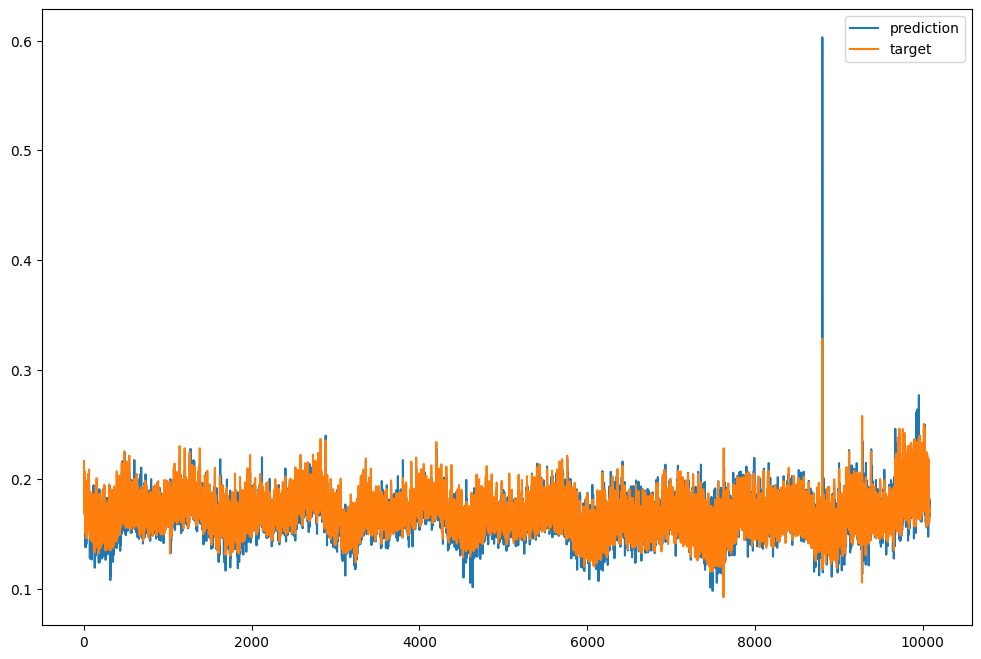

In [38]:
target=list(target.values.reshape(-1))

fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

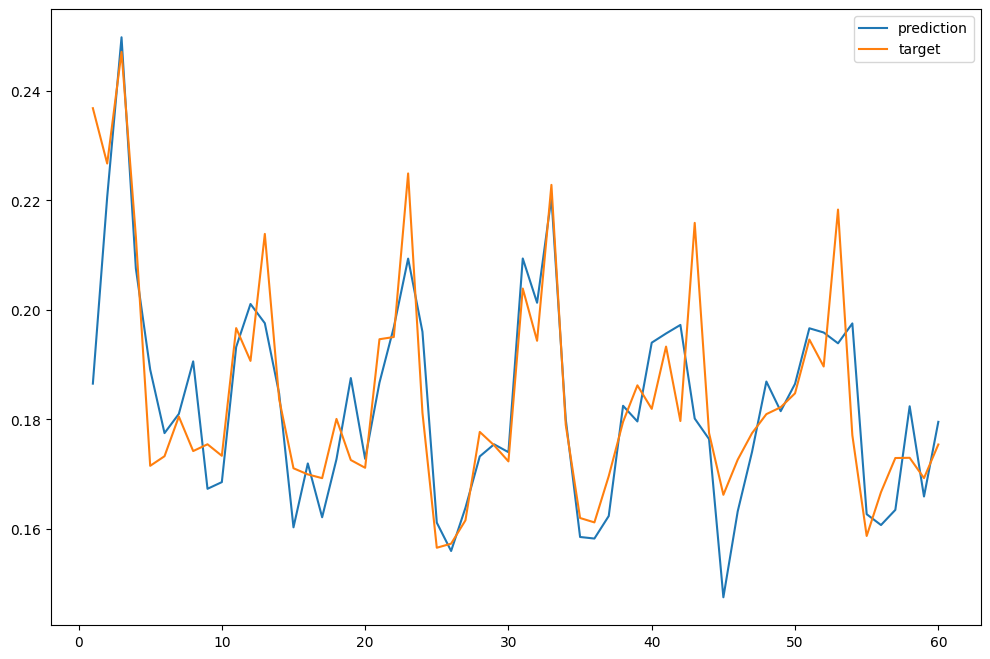

In [39]:
target = data.iloc[-split:]
target=list(target.values.reshape(-1))
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

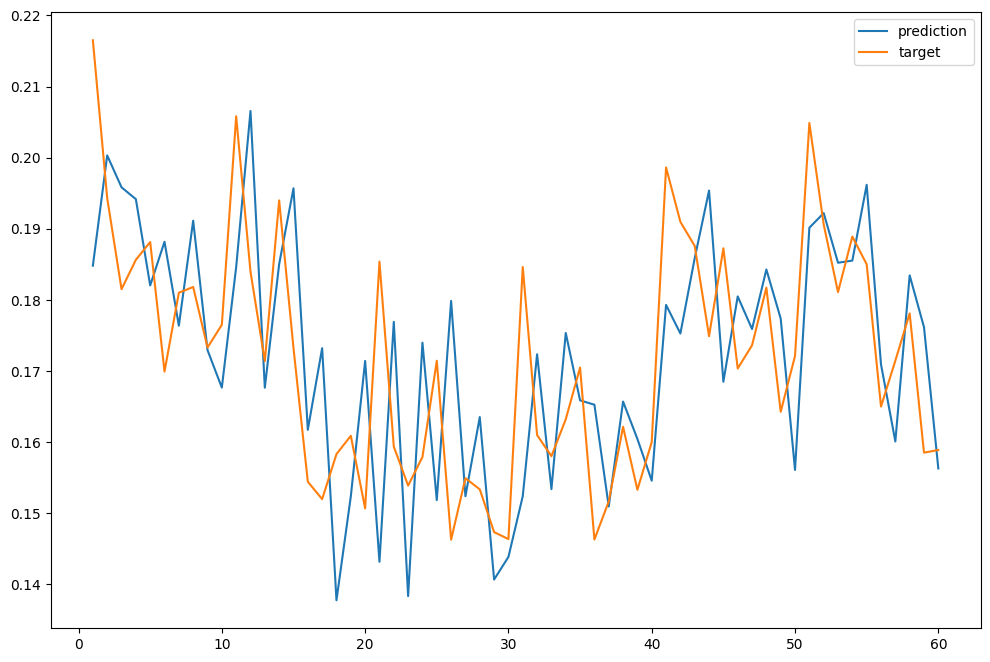

In [40]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[:60],label='prediction')
axes.plot(np.arange(1,61),target[:60],label='target')
axes.legend()

In [41]:
print('SMAPE',SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),
                      FloatTensor(np.array(target).reshape(-1,1))).item()*100,'%')
print('RMSE',RMSE()(FloatTensor(np.array(pred_list).reshape(-1,1)),
                    FloatTensor(np.array(target).reshape(-1,1))).item())
print('MAPE',MAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),
                    FloatTensor(np.array(target).reshape(-1,1))).item()*100,'%')

SMAPE 5.340263620018959 %
RMSE 0.012896626256406307
MAPE 5.343467369675636 %


In [42]:
target

[0.216504,
 0.19432,
 0.181504,
 0.18564,
 0.188136,
 0.169928,
 0.181008,
 0.181824,
 0.173304,
 0.176504,
 0.205824,
 0.18396,
 0.171392,
 0.193992,
 0.17324,
 0.15444,
 0.151992,
 0.15832,
 0.160896,
 0.150688,
 0.185384,
 0.159376,
 0.153896,
 0.157912,
 0.171448,
 0.146296,
 0.154928,
 0.153368,
 0.147352,
 0.146376,
 0.184632,
 0.161,
 0.158032,
 0.163216,
 0.170496,
 0.146312,
 0.151656,
 0.16216,
 0.153304,
 0.160008,
 0.198624,
 0.190976,
 0.187584,
 0.174904,
 0.187256,
 0.17036,
 0.173616,
 0.181728,
 0.164272,
 0.17212,
 0.20488,
 0.190616,
 0.181096,
 0.188904,
 0.185008,
 0.165008,
 0.171456,
 0.178104,
 0.158528,
 0.158896,
 0.20876,
 0.193304,
 0.179312,
 0.181544,
 0.180384,
 0.161056,
 0.16776,
 0.16932,
 0.170888,
 0.14888,
 0.184864,
 0.174064,
 0.166296,
 0.15968,
 0.172392,
 0.146552,
 0.146224,
 0.14824,
 0.145208,
 0.148168,
 0.178864,
 0.168608,
 0.163344,
 0.163008,
 0.170496,
 0.148688,
 0.159864,
 0.162392,
 0.1642,
 0.143688,
 0.18736,
 0.166888,
 0.157056,

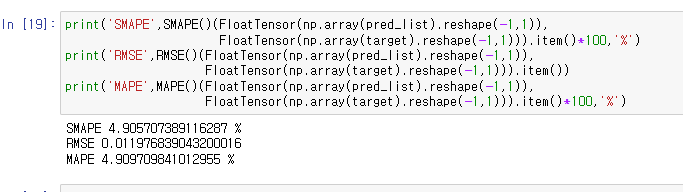
5,65 kernel일때
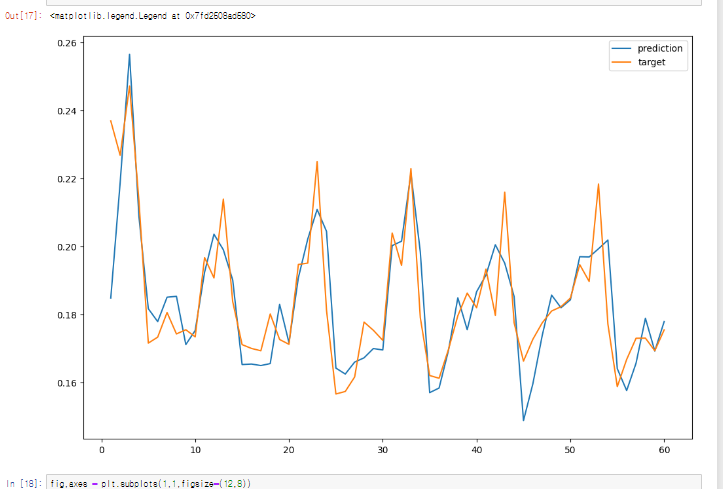
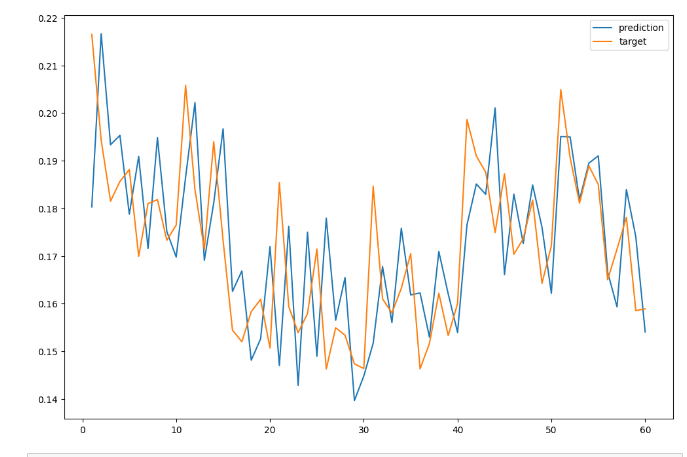